In [26]:
import numpy as np
from qiskit import *
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import (QuantumCircuit, execute, Aer, assemble)
from qiskit.visualization import plot_histogram, plot_bloch_multivector

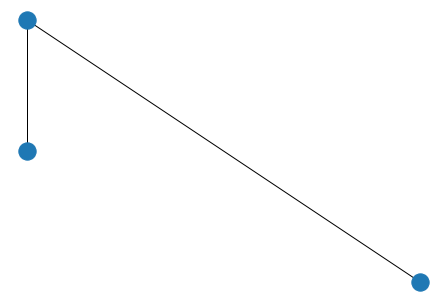

In [27]:
G = nx.Graph()
G.add_edges_from([[2, 3],[2, 1]])
nx.draw(G, pos=nx.bipartite_layout(G, [0, 1, 2]))


In [28]:
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import op_converter
from qiskit.aqua.operators import WeightedPauliOperator

In [29]:
def append_zz_term(qc, q1, q2, gamma):
    """Задаєм блок-схему експоненти Гамільтоніана"""
    qc.barrier()
    qc.cx(q1, q2)
    qc.rz(2 * gamma, q2)
    qc.cx(q1, q2)
    qc.barrier()


In [30]:
def get_cost_op_circ(G, gamma):
    """Задаєм саму квантову схему та її розмірність"""
    N = G.number_of_nodes()
    qc = QuantumCircuit(N, N)
    
    for i, j in G.edges():
        append_zz_term(qc, i-1, j-1, gamma)
 
    return qc

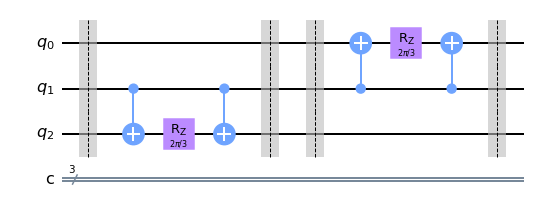

In [31]:
qc = get_cost_op_circ(G, np.pi / 3)
qc.draw(output = 'mpl')

In [32]:
def append_x_term(qc, q1, beta):
    qc.rx(2 * beta, q1)


def get_mixer_operator_circ(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N, N)

    for n in G.nodes():
        append_x_term(qc, n-1, gamma)

    return qc

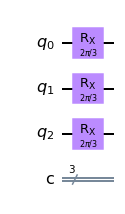

In [33]:
qc = get_mixer_operator_circ(G, np.pi / 3)
qc.draw(output='mpl')

In [34]:
def get_qaoa_circ(G, beta, gamma):
    assert (len(beta) == len(gamma)) # коли умова виконується, програма продовжує працювати
    p = len(beta)
    N = G.number_of_nodes()
    qc = QuantumCircuit(N, N)
    qc.h(range(N))

    for i in range(p):
        qc += get_cost_op_circ(G, gamma[i])
        qc.barrier(range(N))
        qc += get_mixer_operator_circ(G, beta[i])
        
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    return qc

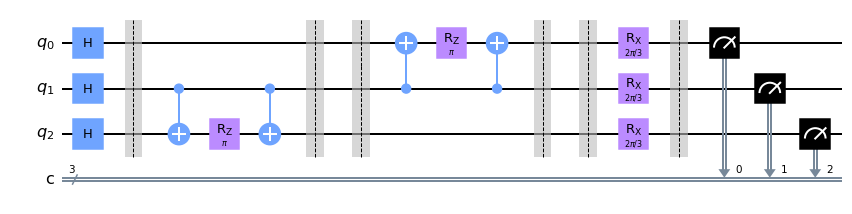

In [35]:
qc = get_qaoa_circ(G, [np.pi / 3.], [np.pi / 2])
qc.draw(output='mpl')

In [36]:
def invert_counts(counts):
    return {k[::-1]: v for k, v in counts.items()}

In [37]:
sim = Aer.get_backend('qasm_simulator')
res = execute(qc,backend=sim).result()
print(invert_counts(res.get_counts()))

{'110': 123, '010': 144, '001': 144, '000': 114, '111': 126, '100': 113, '011': 126, '101': 134}


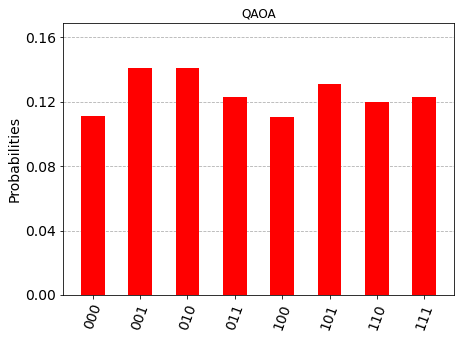

In [38]:
plot_histogram(invert_counts(res.get_counts(qc)), color='red', bar_labels=False, title='QAOA')

In [39]:
def maxcut_obj(x, G):
    cutt = 0
    for i, j in G.edges():
        if x[i-1] != x[j-1]:
            cutt -= 1
    return cutt

# maxcut_obj('0011', G)

In [40]:
def compute_maxcut_energy(counts, G):
    energy = 0
    tot_counts = 0

    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        tot_counts += meas_count
    return energy / tot_counts


compute_maxcut_energy(invert_counts(res.get_counts(qc)), G)

-1.037109375

In [41]:
def get_black_box_obj(G, p):
    sim = Aer.get_backend('qasm_simulator')

    def f(theta):
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circ(G, beta, gamma)
        counts = execute(qc, sim, seed_simulator=10).result().get_counts()
        return compute_maxcut_energy(invert_counts(counts), G)

    return f

In [42]:
p = 5 # кількість кроків виконання роботи (збільшення точності обрахунків)
obj = get_black_box_obj(G, p)
initial_point = np.array([0.81, 2.2, 0.83, 2.15, 0.37, 2.42, 6.15, 2.24, 3.85, 6.1])
res_sample = minimize(obj, initial_point, method='COBYLA', options={'maxiter': 2500, 'disp': True})
print(res_sample)

     fun: -1.998046875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 99
  status: 1
 success: True
       x: array([2.28188072, 2.90017845, 0.78336037, 3.10966962, 0.25405383,
       2.50499513, 6.10988925, 2.06580165, 3.85316923, 6.08956348])


In [43]:
optimal_theta = res_sample['x']

qc = get_qaoa_circ(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, sim).result().get_counts())
print(f'\n{counts=}')


counts={'010': 505, '101': 519}


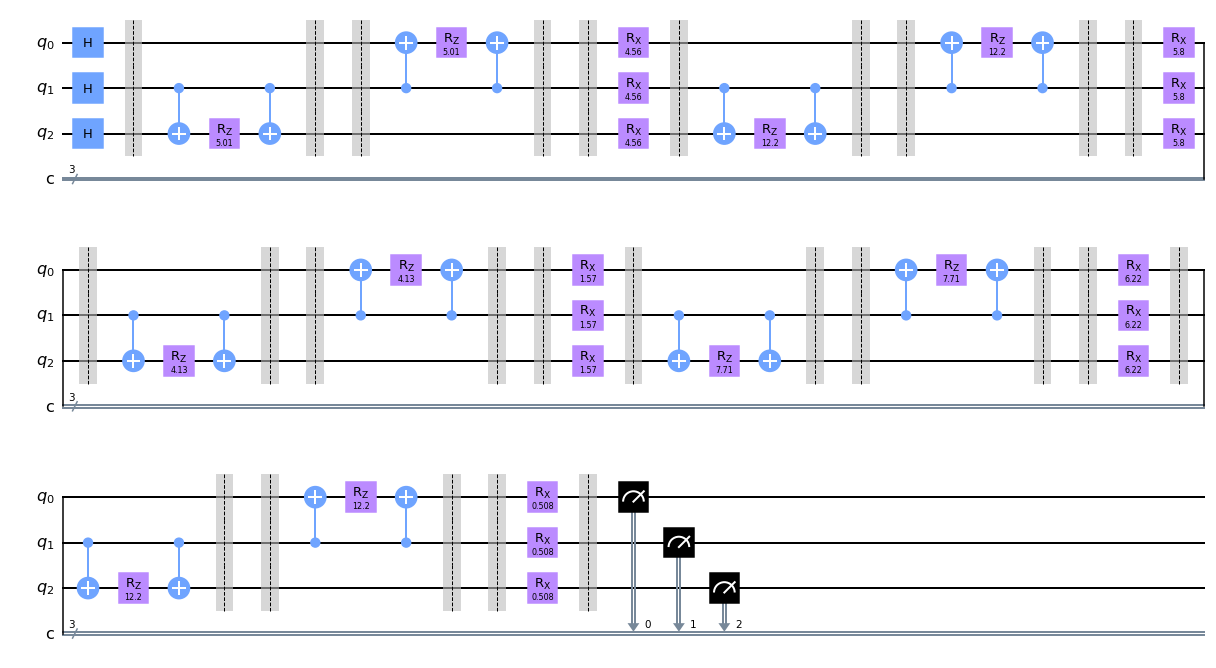

In [44]:
qc.draw(output='mpl')

In [45]:
best_cut, best_solution = min([(maxcut_obj(x, G), x) for x in counts.keys()], key=itemgetter(0))
print(f'The best string is:{best_solution} with cut {-best_cut}')

The best string is:010 with cut 2


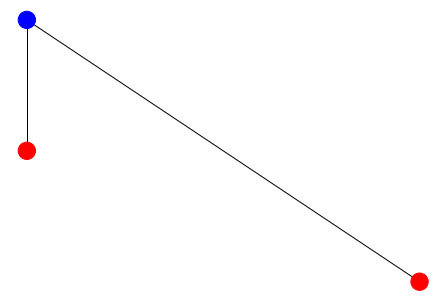

In [46]:
colors = ['red' if best_solution[node-1] == '0' else 'blue' for node in G]
nx.draw(G, node_color=colors, pos=nx.bipartite_layout(G, [0, 1, 2]))

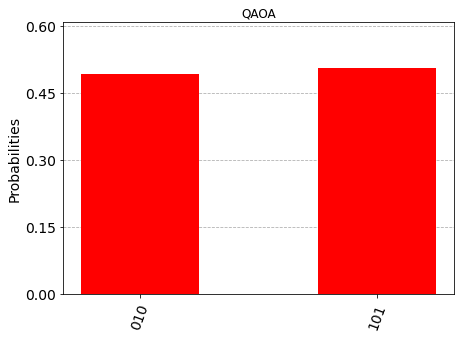

In [47]:
plot_histogram(counts, color='red', bar_labels=False, title='QAOA')

In [48]:
# Real Quantum Computers
from qiskit import IBMQ

# used only for first time, then you should use IBMQ.load_account()
# TOKEN = 'smth from IBM API token'
# IBMQ.save_account(TOKEN)

IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q')
m_backend = 'ibmq_5_yorktown'
# m_backend = 'ibmq_santiago'
device = provider.get_backend(m_backend)

In [49]:
job = execute(
    qc, 
    backend=device, 
    shots=1024, 
    memory = True)

In [50]:
print(f'{job.job_id() = }')
from qiskit.tools.monitor import job_monitor
# Status of real job in real Quantum Computer
job_monitor(job)

job.job_id() = '608917e92ddd43579af080b5'
Job Status: job has successfully run


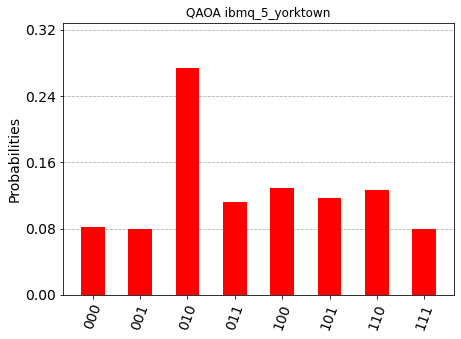

In [51]:
counts = job.result().get_counts(qc)
plot_histogram(counts, color='red', bar_labels=False, title='QAOA '+ str(m_backend))